# Clustering teams based on their playstyle and league

In [97]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score, davies_bouldin_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import permutations

In [98]:
# Step 1: Load the processed data
file_path = '../data/final_team_cluster_data2.csv'
final_team_cluster_data = pd.read_csv(file_path)

In [99]:
# Add league information from the matches dataset
matches_file_path = '../data/ginf.csv'
matches_data = pd.read_csv(matches_file_path)
team_league_map = pd.concat([matches_data[['ht', 'league']], matches_data[['at', 'league']].rename(columns={'at': 'ht'})])
team_league_map = team_league_map.drop_duplicates().set_index('ht')['league'].to_dict()
final_team_cluster_data['league'] = final_team_cluster_data['event_team'].map(team_league_map)


In [100]:
# Verify league column
print("\nNumber of Teams from Each League:")
print(final_team_cluster_data['league'].value_counts())


Number of Teams from Each League:
league
F1     30
I1     30
SP1    30
E0     26
D1     26
Name: count, dtype: int64


In [101]:
# Step 2: Prepare data for clustering
team_names = final_team_cluster_data['event_team']
league_labels = final_team_cluster_data['league']  # Actual league labels
clustering_features = final_team_cluster_data.drop(columns=['event_team', 'league'])

In [102]:
# Step 3: Apply RandomOverSampler
print("\nBefore Oversampling:")
print(final_team_cluster_data['league'].value_counts())


Before Oversampling:
league
F1     30
I1     30
SP1    30
E0     26
D1     26
Name: count, dtype: int64


In [103]:
# Use oversampling to balance the dataset based on league labels
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(clustering_features, league_labels)

In [104]:
print("\nAfter Oversampling:")
print(pd.Series(y_resampled).value_counts())


After Oversampling:
league
F1     30
I1     30
SP1    30
E0     30
D1     30
Name: count, dtype: int64


In [105]:
# Create a new DataFrame with oversampled data
oversampled_data = pd.DataFrame(X_resampled, columns=clustering_features.columns)
oversampled_data['league'] = y_resampled

C:\Users\stoic\AppData\Local\Temp\ipykernel_20004\2535875407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  oversampled_data['league'] = y_resampled


In [106]:
# Step 4: Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(oversampled_data.drop(columns=['league']))
oversampled_data_scaled = pd.DataFrame(scaled_features, columns=clustering_features.columns)
oversampled_data_scaled['league'] = y_resampled

In [107]:
# Step 5: Apply BIRCH clustering
best_model = None
best_metrics = {'score': -np.inf}
threshold_values = np.linspace(0.1, 0.9, 9)
n_clusters = 5  # Fixed to 5 for league clustering
weights = {
    'silhouette': 0.4,
    'davies_bouldin': -0.3,
    'ari': 0.15,
    'homogeneity': 0.1,
    'completeness': 0.05
}

In [108]:
for threshold in tqdm(threshold_values, desc="Tuning BIRCH"):
    birch_model = Birch(n_clusters=n_clusters, threshold=threshold)
    birch_model.fit(oversampled_data_scaled.drop(columns=['league']))
    labels = birch_model.labels_

    if len(set(labels)) > 1:
        silhouette = silhouette_score(oversampled_data_scaled.drop(columns=['league']), labels)
        dbi = davies_bouldin_score(oversampled_data_scaled.drop(columns=['league']), labels)
        ari = adjusted_rand_score(y_resampled, labels)
        homogeneity = homogeneity_score(y_resampled, labels)
        completeness = completeness_score(y_resampled, labels)

        weighted_score = (
            weights['silhouette'] * silhouette +
            weights['davies_bouldin'] * (1 / (1 + dbi)) +
            weights['ari'] * ari +
            weights['homogeneity'] * homogeneity +
            weights['completeness'] * completeness
        )

        if weighted_score > best_metrics['score']:
            best_metrics = {
                'score': weighted_score,
                'silhouette': silhouette,
                'davies_bouldin': dbi,
                'ari': ari,
                'homogeneity': homogeneity,
                'completeness': completeness,
                'threshold': threshold
            }
            best_model = birch_model

Tuning BIRCH: 100%|██████████| 9/9 [00:00<00:00, 46.55it/s]


In [109]:
# Print the best hyperparameters and metrics
print("\nBest BIRCH Model:")
for metric, value in best_metrics.items():
    if metric != 'score':
        print(f"{metric.capitalize()}: {value:.2f}")
print(f"Weighted Score: {best_metrics['score']:.2f}")


Best BIRCH Model:
Silhouette: 0.18
Davies_bouldin: 1.74
Ari: 0.19
Homogeneity: 0.32
Completeness: 0.37
Threshold: 0.10
Weighted Score: 0.04


In [110]:
# Assign clusters
oversampled_data_scaled['cluster'] = best_model.labels_

In [111]:
# Step 6: Predict leagues for each cluster
cluster_league_df = oversampled_data_scaled[['cluster', 'league']]

In [112]:
# Calculate league proportions within each cluster
league_distribution = cluster_league_df.groupby(['cluster', 'league']).size().unstack(fill_value=0)
league_distribution_normalized = league_distribution.div(league_distribution.sum(axis=1), axis=0)


In [113]:
# Actual league proportions
real_league_counts = oversampled_data_scaled['league'].value_counts()
real_league_proportions = real_league_counts / real_league_counts.sum()

In [114]:
# Generate all possible mappings between clusters and leagues
possible_mappings = list(permutations(real_league_counts.index, len(league_distribution)))


In [115]:
def calculate_fit_score(mapping, league_distribution, real_league_proportions):
    score = 0
    for cluster, league in enumerate(mapping):
        cluster_league_proportion = league_distribution.iloc[cluster].get(league, 0)
        league_proportion = real_league_proportions.get(league, 0)
        score += cluster_league_proportion * league_proportion
    return score

In [116]:
# Find the best mapping
best_mapping = None
best_score = -np.inf
for mapping in possible_mappings:
    score = calculate_fit_score(mapping, league_distribution, real_league_proportions)
    if score > best_score:
        best_score = score
        best_mapping = mapping

In [117]:
# Print the best mapping
cluster_to_league_mapping = {cluster: league for cluster, league in enumerate(best_mapping)}
print("\nBest Cluster-to-League Mapping:")
for cluster, league in cluster_to_league_mapping.items():
    print(f"Cluster {cluster}: {league}")


Best Cluster-to-League Mapping:
Cluster 0: I1
Cluster 1: E0
Cluster 2: F1
Cluster 3: D1
Cluster 4: SP1


In [118]:
# Assign predicted leagues
oversampled_data_scaled['predicted_league'] = oversampled_data_scaled['cluster'].map(cluster_to_league_mapping)


In [119]:
# Step 7: Compute Accuracy
accuracy = (oversampled_data_scaled['predicted_league'] == oversampled_data_scaled['league']).mean()
print(f"\nClustering Accuracy: {accuracy:.2f}")


Clustering Accuracy: 0.43


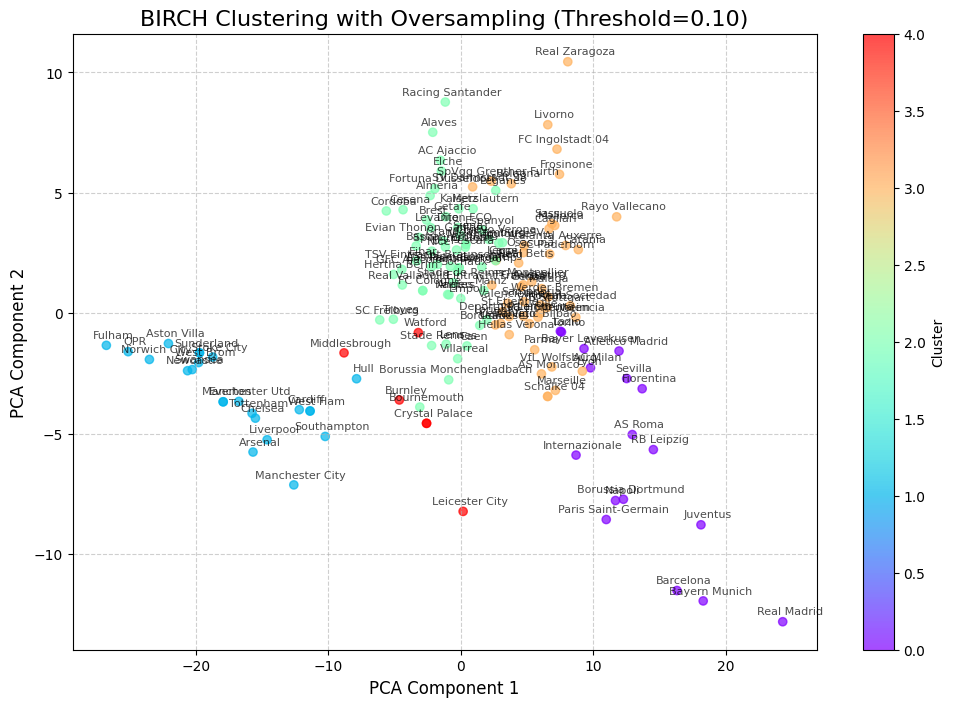


Number of Teams from Each League:
league
F1     30
I1     30
SP1    30
E0     30
D1     30
Name: count, dtype: int64


In [120]:
# Step 8: Visualize Clusters with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(oversampled_data_scaled.drop(columns=['league', 'cluster', 'predicted_league']))
oversampled_data_scaled['pca_x'] = pca_features[:, 0]
oversampled_data_scaled['pca_y'] = pca_features[:, 1]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    oversampled_data_scaled['pca_x'], 
    oversampled_data_scaled['pca_y'], 
    c=oversampled_data_scaled['cluster'], 
    cmap='rainbow', 
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster')
plt.title(f'BIRCH Clustering with Oversampling (Threshold={best_metrics["threshold"]:.2f})', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

# Annotate team names
for i, team in enumerate(team_names):
    plt.annotate(
        team,
        (oversampled_data_scaled['pca_x'][i], oversampled_data_scaled['pca_y'][i]),
        fontsize=8,
        alpha=0.7,
        textcoords="offset points",
        xytext=(5, 5),
        ha='center'
    )
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# For curiosity, print final league distribution
print("\nNumber of Teams from Each League:")
print(oversampled_data_scaled['league'].value_counts())